* Import external libraries:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.collections
plt.style.use(['science', 'notebook', 'grid'])
import numpy as np
from scipy.spatial import cKDTree

### Base

In [4]:
box = [10, 10]
vel = 0.5  # initial velocity
radius = 0.2
steps = 300

In [5]:
def data_creater(n_particles):
    angle = np.random.uniform(low=0, high=2*np.pi, size=n_particles)  # random initial directions
    r = np.zeros((2,n_particles))
    r[0] = np.random.uniform(low=radius, high=box[0]/2-radius, size=n_particles)  # random initial positions
    r[1] = np.random.uniform(low=radius, high=box[1]-radius, size=n_particles)  # random initial positions
    v = np.zeros((2,n_particles))
    for i in range(n_particles):
        v[0][i] = vel * np.cos(angle[i])
        v[1][i] = vel * np.sin(angle[i])
    return r, v

### Particles in the begining (time = 0)

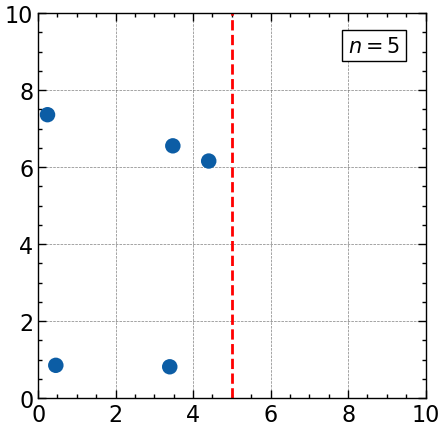

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data = data_creater(5)
x, y = data[0][0], data[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
ax.text(0.8, 0.9, '$n = 5$', size=15, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
ax.axvline(x=box[0]/2, ymin=0, ymax=box[1], c='red', ls='--')
plt.show()

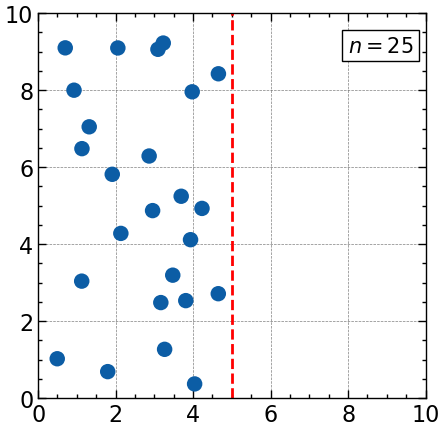

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data = data_creater(25)
x, y = data[0][0], data[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
ax.text(0.8, 0.9, '$n = 25$', size=15, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
ax.axvline(x=box[0]/2, ymin=0, ymax=box[1], c='red', ls='--')
plt.show()

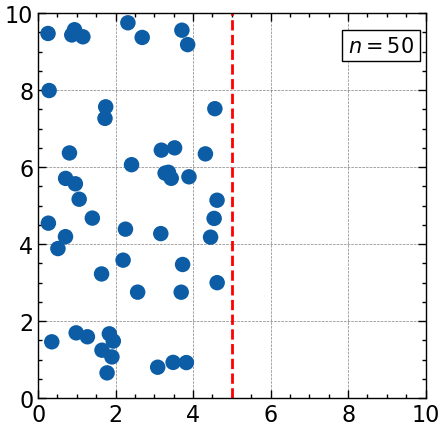

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data = data_creater(50)
x, y = data[0][0], data[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
ax.text(0.8, 0.9, '$n = 50$', size=15, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
ax.axvline(x=box[0]/2, ymin=0, ymax=box[1], c='red', ls='--')
plt.show()

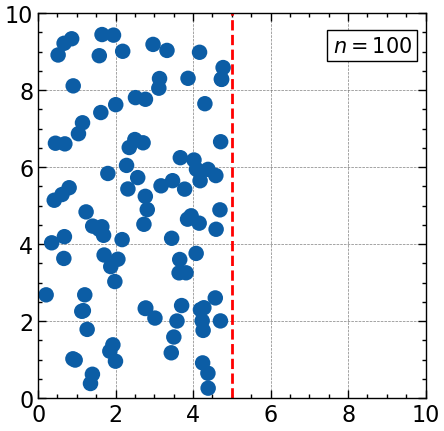

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data = data_creater(100)
x, y = data[0][0], data[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
ax.text(0.76, 0.9, '$n = 100$', size=15, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
ax.axvline(x=box[0]/2, ymin=0, ymax=box[1], c='red', ls='--')
plt.show()

### Simulation

* Velocities after collision:
$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

* Functions used for simulation

In [13]:
def compute_new_v(v1, v2, r1, r2):
    """calculates velocity after collision"""
    v1_new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2_new = v2 - np.diag((v2-v1).T@(r2-r1))/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1_new, v2_new


def motion(r, v, ts, dt):
    """calculates position of each particle with time step dt"""
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1, ts):
        my_tree = cKDTree(r.T)
        pairs = np.array(sorted(list(my_tree.query_pairs(r=2*radius))))  # finding collisions using nearest neighbour
        if pairs.size > 0:    
            v[:, pairs[:,0]], v[:, pairs[:,1]] = compute_new_v(v[:, pairs[:,0]], v[:, pairs[:,1]], r[:, pairs[:,0]], r[:,pairs[:,1]])
        
        v[0, (r[0] + radius) > box[0]] = -np.abs(v[0, (r[0] + radius) > box[0]])
        v[0, (r[0] - radius) < 0] = np.abs(v[0, (r[0] - radius) < 0])
        v[1, (r[1] + radius) > box[1]] = -np.abs(v[1, (r[1] + radius) > box[1]])
        v[1, (r[1] - radius) < 0] = np.abs(v[1, (r[1] - radius) < 0])
        
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

In [14]:
def simulation(k):
    N = [5, 25, 50, 100]
    r_5, r_25, r_50, r_100 = [], [], [], []
    v_5, v_25, v_50, v_100 = [], [], [], []
    for _ in range(k):
        for n in N:
            r, v = data_creater(n)
            rs, vs = motion(r, v, ts=steps, dt=1)
            if n == 5:
                r_5.append(rs)
                v_5.append(vs)
            if n == 25:
                r_25.append(rs)
                v_25.append(vs)
            if n == 50:
                r_50.append(rs)
                v_50.append(vs)
            if n == 100:
                r_100.append(rs)
                v_100.append(vs)
    r = [r_5, r_25, r_50, r_100]
    v = [v_5, v_25, v_50, v_100]
    return r, v

### Running the simulations

In [15]:
r_sim, v_sim = [], []
for k in [5, 25, 50]:
    r_sim.append(simulation(k)[0])
    v_sim.append(simulation(k)[1])

### Calculating	the	Entropy	over time

* Number of particles being on the left side at time t:

In [16]:
def n_left(r):
    left_n = np.zeros(steps)
    for time in range(steps):
        temp = r[time][0]
        temp = temp[temp <= (box[0]/2) - radius]
        left_n[time] = len(temp)
    return left_n

In [17]:
M = [5, 25, 50]
N = [5, 25, 50, 100]
left = []
for i, j in enumerate(M):
    for k in range(len(N)):
        for n in range(j):
            left.append(n_left(r_sim[i][k][n]))
left_n = np.array(left)

* Probability:

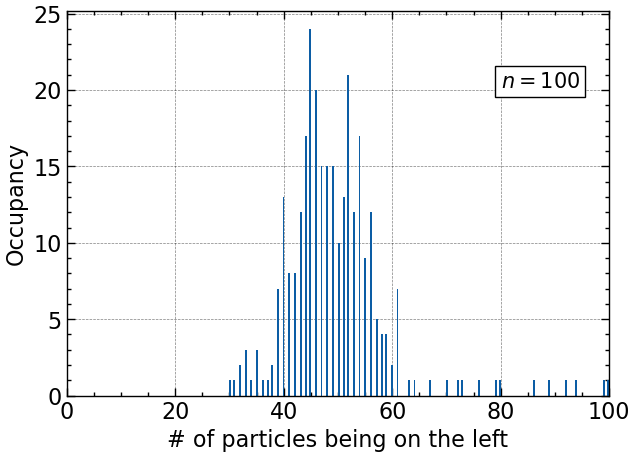

In [27]:
x = 285
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(left_n[x], bins=int(left_n[x][0])*2)
ax.set_xlim(0, left_n[x][0])
ax.set_ylabel('Occupancy')
ax.set_xlabel('# of particles being on the left')
ax.text(0.8, 0.8, f'$n = {int(left_n[x][0])}$', size=15, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
plt.show()

* $S(t)=-\sum_{i=0}^{N}p_{i}(t) \ln{p_{i}(t)}$
* ${t\to\infty}\implies p_{i}(\infty)=\frac{1}{2}\implies \ln{p_{i}(\infty)}\simeq-0.693147\implies S(\infty)\simeq0.346573$

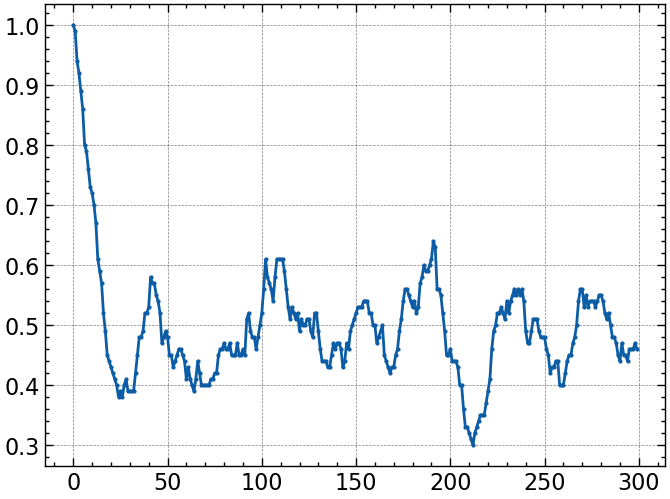

In [28]:
p = left_n[x]/left_n[x][0]
time = np.arange(0, steps, 1)
plt.plot(time, p, '-o', ms=2)
plt.show()

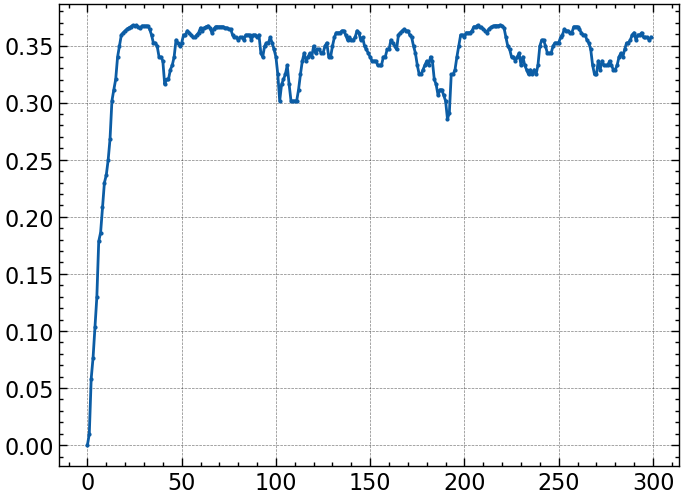

In [29]:
s = -p * np.log(p)
plt.plot(time, s, '-o', ms=2)
plt.show()